# English Premier League Player Suggestion
* The data file comes from kaggle: https://www.kaggle.com/datasets/rishikeshkanabar/premier-league-player-statistics-updated-daily/data
* We also downloaded a FIFA 21 file as the original data file does not have the positions of players categorized in depth. 
    * https://www.kaggle.com/datasets/aayushmishra1512/fifa-2021-complete-player-data
* The data is also, all-time statitics. In another words, it's not based on a single season but based on all the years each players have spent in the English Premier League
    * Therefore, some players may have more data than others. 

## Purpose 
* The goal of this project is to leverage unsupervised learning techniques to recommend similar football players based on their playing style and attributes.
* In football, players get transferred to different teams, players leave at the end of contracts and sometimes players get injured. When these occurences happen, you need to replace the players. Sometimes you may want to replace them with players with similar style as previous players or sometimes you may want a certain player but that player may not be available and you want to look for someone who has similar attributes. 
* For this project, we will prompt the user to enter a player's name, and using unsupervised learning (clustering), the model will return a list of players with similar attributes. 

## Read in Libraries

In [319]:
# read in libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## Read in Data files

In [320]:
# read in file 
df = pd.read_csv('dataset - 2020-09-24.csv')
df.head()

,Name,Jersey Number,Club,Position,Nationality,Age,Appearances,Wins,Losses,Goals,...,Punches,High Claims,Catches,Sweeper clearances,Throw outs,Goal Kicks,Yellow cards,Red cards,Fouls,Offsides
0,Bernd Leno,1.0,Arsenal,Goalkeeper,Germany,28.0,64,28,16,0,...,34.0,26.0,17.0,28.0,375.0,489.0,2,0,0,NaN
1,Matt Macey,33.0,Arsenal,Goalkeeper,England,26.0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,NaN
2,Rúnar Alex Rúnarsson,13.0,Arsenal,Goalkeeper,Iceland,25.0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,NaN
3,Héctor Bellerín,2.0,Arsenal,Defender,Spain,25.0,160,90,37,7,...,NaN,NaN,NaN,NaN,NaN,NaN,23,0,125,8.0
4,Kieran Tierney,3.0,Arsenal,Defender,Scotland,23.0,16,7,5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,2,0,9,0.0


In [321]:
fifa = pd.read_csv('FIFA-21 Complete.csv', sep=';')

In [322]:
fifa.head()

,player_id,name,nationality,position,overall,age,hits,potential,team
0,158023,Lionel Messi,Argentina,ST|CF|RW,94,33,299,94,FC Barcelona
1,20801,Cristiano Ronaldo,Portugal,ST|LW,93,35,276,93,Juventus
2,190871,Neymar Jr,Brazil,CAM|LW,92,28,186,92,Paris Saint-Germain
3,203376,Virgil van Dijk,Netherlands,CB,91,29,127,92,Liverpool
4,200389,Jan Oblak,Slovenia,GK,91,27,47,93,Atlético Madrid


## Data Exploration
* Different variables apply to different positions. For instance, 'Punches' are only applicable to Goalkeepers. 

In [323]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571 entries, 0 to 570
Data columns (total 59 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    571 non-null    object 
 1   Jersey Number           563 non-null    float64
 2   Club                    571 non-null    object 
 3   Position                571 non-null    object 
 4   Nationality             570 non-null    object 
 5   Age                     570 non-null    float64
 6   Appearances             571 non-null    int64  
 7   Wins                    571 non-null    int64  
 8   Losses                  571 non-null    int64  
 9   Goals                   571 non-null    int64  
 10  Goals per match         309 non-null    float64
 11  Headed goals            502 non-null    float64
 12  Goals with right foot   502 non-null    float64
 13  Goals with left foot    502 non-null    float64
 14  Penalties scored        309 non-null    fl

### Appearance 
Appearance is the number of games, a player has played

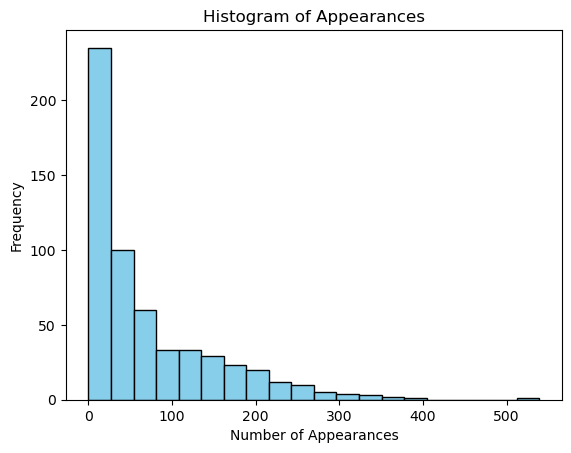

In [324]:
plt.hist(df['Appearances'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Number of Appearances')
plt.ylabel('Frequency')
plt.title('Histogram of Appearances')
plt.show()

## Data Cleaning
1. Remove players who never played or has played in few games only. It would be great if we had data on how many minutes each player has played as it will tell us more about how much game time each player had instead of appearnces. But we do not and thus we will settle for appearance. We will arbitrarily choose 10 matches. 

### Removing Players Appearance < 10 

In [325]:
# check how many players have 0 appearances
(df['Appearances'] < 10).value_counts() # 171

False    400
True     171
Name: Appearances, dtype: int64

In [326]:
df = df[df['Appearances'] >= 10] # removing players with less than 10 appearances
len(df)

400

### Removing unused columns
We only need name and position from the fifa table

In [327]:
fifa.columns

Index(['player_id', 'name', 'nationality', 'position', 'overall', 'age',
       'hits', 'potential', 'team'],
      dtype='object')

In [328]:
fifa_cols = ['name', 'position']
fifa = fifa[fifa_cols]

### Joining df and fifa

In [329]:
df_fifa = pd.merge(
    df, fifa, left_on='Name', right_on='name', how='left'
)

There seems to be 14 duplicated records. 

In [330]:
df_fifa[df_fifa['Name'].duplicated(keep=False)]

,Name,Jersey Number,Club,Position,Nationality,Age,Appearances,Wins,Losses,Goals,...,Catches,Sweeper clearances,Throw outs,Goal Kicks,Yellow cards,Red cards,Fouls,Offsides,name,position
26,Emiliano Martínez,26.0,Aston-Villa,Goalkeeper,Argentina,28.0,16,9,6,0,...,6.0,4.0,86.0,103.0,2,0,1,NaN,Emiliano Martínez,GK
27,Emiliano Martínez,26.0,Aston-Villa,Goalkeeper,Argentina,28.0,16,9,6,0,...,6.0,4.0,86.0,103.0,2,0,1,NaN,Emiliano Martínez,CM
44,Jota,23.0,Aston-Villa,Midfielder,Spain,29.0,10,2,7,0,...,NaN,NaN,NaN,NaN,0,0,6,0.0,Jota,RM|RW
45,Jota,23.0,Aston-Villa,Midfielder,Spain,29.0,10,2,7,0,...,NaN,NaN,NaN,NaN,0,0,6,0.0,Jota,RM|LM
53,Bernardo,30.0,Brighton-and-Hove-Albion,Defender,Brazil,25.0,36,9,16,0,...,NaN,NaN,NaN,NaN,5,0,20,6.0,Bernardo,LB|LWB|LW
54,Bernardo,30.0,Brighton-and-Hove-Albion,Defender,Brazil,25.0,36,9,16,0,...,NaN,NaN,NaN,NaN,5,0,20,6.0,Bernardo,CB
93,Reece James,24.0,Chelsea,Defender,England,20.0,26,15,8,1,...,NaN,NaN,NaN,NaN,1,0,24,1.0,Reece James,RB|CDM
94,Reece James,24.0,Chelsea,Defender,England,20.0,26,15,8,1,...,NaN,NaN,NaN,NaN,1,0,24,1.0,Reece James,LB
97,Emerson,33.0,Chelsea,Defender,Italy,26.0,30,11,14,0,...,NaN,NaN,NaN,NaN,3,0,15,2.0,Emerson,LB|LM
98,Emerson,33.0,Chelsea,Defender,Italy,26.0,30,11,14,0,...,NaN,NaN,NaN,NaN,3,0,15,2.0,Emerson,RWB|RB|RM|RW


Looks like we can safely remove the duplicates

In [331]:
df_fifa=df_fifa.drop_duplicates(subset='Name')

#### Check if any data missing from fifa side
There are 25 data points in df that did not have a matching name from fifa. Let's see who these players are

In [332]:
df_fifa['name'].isna().value_counts()

False    375
True      25
Name: name, dtype: int64

We know that goalkeepers do not have any specialized categories such as LB, CAM, CDM and therefore, we can safely assign "GK" to all players who are Goalkeepers and missing data.

In [333]:
df_fifa[df_fifa['position'].isna()]

,Name,Jersey Number,Club,Position,Nationality,Age,Appearances,Wins,Losses,Goals,...,Catches,Sweeper clearances,Throw outs,Goal Kicks,Yellow cards,Red cards,Fouls,Offsides,name,position
8,Sead Kolasinac,31.0,Arsenal,Defender,Bosnia And Herzegovina,27.0,78,40,22,2,...,NaN,NaN,NaN,NaN,12,0,74,16.0,NaN,NaN
14,Matteo Guendouzi,29.0,Arsenal,Midfielder,France,21.0,57,24,17,0,...,NaN,NaN,NaN,NaN,15,0,41,0.0,NaN,NaN
29,Ezri Konsa Ngoyo,4.0,Aston-Villa,Defender,England,22.0,26,8,12,2,...,NaN,NaN,NaN,NaN,3,0,17,1.0,NaN,NaN
33,Ahmed El Mohamady,27.0,Aston-Villa,Defender,Egypt,33.0,183,48,91,6,...,NaN,NaN,NaN,NaN,12,1,152,13.0,NaN,NaN
42,Trézéguet,17.0,Aston-Villa,Midfielder,Egypt,25.0,35,9,19,6,...,NaN,NaN,NaN,NaN,2,1,39,6.0,NaN,NaN
49,Mat Ryan,1.0,Brighton-and-Hove-Albion,Goalkeeper,Australia,28.0,112,27,50,0,...,17.0,15.0,491.0,956.0,2,0,2,NaN,NaN,NaN
78,Jóhann Gudmundsson,7.0,Burnley,Midfielder,Iceland,29.0,96,28,44,7,...,NaN,NaN,NaN,NaN,5,0,41,6.0,NaN,NaN
87,Kepa Arrizabalaga,1.0,Chelsea,Goalkeeper,Spain,25.0,71,39,20,0,...,9.0,22.0,320.0,473.0,2,0,0,NaN,NaN,NaN
95,César Azpilicueta,28.0,Chelsea,Defender,Spain,31.0,272,158,56,8,...,NaN,NaN,NaN,NaN,23,1,240,10.0,NaN,NaN
111,Vicente Guaita,31.0,Crystal-Palace,Goalkeeper,Spain,33.0,57,23,21,0,...,18.0,14.0,263.0,478.0,3,0,1,NaN,NaN,NaN


In [334]:
print(df_fifa['position'].value_counts())

CB              58
ST              42
CDM|CM          42
GK              29
CM              14
                ..
LB|LWB|LM|LW     1
ST|RW|LW         1
CAM|LW           1
LW               1
LB|LM|CM         1
Name: position, Length: 74, dtype: int64


In [335]:
df_fifa['position'] = np.where(
    df_fifa['Position'] == 'Goalkeeper', 'GK', df_fifa['position']
)
print(df_fifa['position'].value_counts())

CB              58
ST              42
CDM|CM          42
GK              34
CM              14
                ..
LB|LWB|LM|LW     1
ST|RW|LW         1
CAM|LW           1
LW               1
LB|LM|CM         1
Name: position, Length: 74, dtype: int64


Check again

In [336]:
df_fifa[df_fifa['position'].isna()]

,Name,Jersey Number,Club,Position,Nationality,Age,Appearances,Wins,Losses,Goals,...,Catches,Sweeper clearances,Throw outs,Goal Kicks,Yellow cards,Red cards,Fouls,Offsides,name,position
8,Sead Kolasinac,31.0,Arsenal,Defender,Bosnia And Herzegovina,27.0,78,40,22,2,...,NaN,NaN,NaN,NaN,12,0,74,16.0,NaN,NaN
14,Matteo Guendouzi,29.0,Arsenal,Midfielder,France,21.0,57,24,17,0,...,NaN,NaN,NaN,NaN,15,0,41,0.0,NaN,NaN
29,Ezri Konsa Ngoyo,4.0,Aston-Villa,Defender,England,22.0,26,8,12,2,...,NaN,NaN,NaN,NaN,3,0,17,1.0,NaN,NaN
33,Ahmed El Mohamady,27.0,Aston-Villa,Defender,Egypt,33.0,183,48,91,6,...,NaN,NaN,NaN,NaN,12,1,152,13.0,NaN,NaN
42,Trézéguet,17.0,Aston-Villa,Midfielder,Egypt,25.0,35,9,19,6,...,NaN,NaN,NaN,NaN,2,1,39,6.0,NaN,NaN
78,Jóhann Gudmundsson,7.0,Burnley,Midfielder,Iceland,29.0,96,28,44,7,...,NaN,NaN,NaN,NaN,5,0,41,6.0,NaN,NaN
95,César Azpilicueta,28.0,Chelsea,Defender,Spain,31.0,272,158,56,8,...,NaN,NaN,NaN,NaN,23,1,240,10.0,NaN,NaN
126,Jairo Riedewald,44.0,Crystal-Palace,Midfielder,Netherlands,24.0,29,8,13,0,...,NaN,NaN,NaN,NaN,0,0,6,0.0,NaN,NaN
141,Gylfi Sigurdsson,10.0,Everton,Midfielder,Iceland,31.0,284,114,110,61,...,NaN,NaN,NaN,NaN,20,0,193,16.0,NaN,NaN
146,Muhamed Besic,30.0,Everton,Midfielder,Bosnia And Herzegovina,28.0,46,14,17,0,...,NaN,NaN,NaN,NaN,11,0,42,0.0,NaN,NaN


In [337]:
# creating a dictionary
missing_position_players = df_fifa[df_fifa['position'].isna()]
missing_position_dict = dict(zip(missing_position_players['Name'], missing_position_players['position']))

In [338]:
for player, position in missing_position_dict.items():
    print(player)

Sead Kolasinac
Matteo Guendouzi
Ezri Konsa Ngoyo
Ahmed El Mohamady
Trézéguet
Jóhann Gudmundsson
César Azpilicueta
Jairo Riedewald
Gylfi Sigurdsson
Muhamed Besic
Jean Michael Seri
André-Frank Zambo Anguissa
Bobby De Cordova-Reid
Rodrigo Moreno
Joseph Gomez
Naby Keita
Javier Manquillo
William Smallbone
Son Heung-Min
Branislav Ivanovic


Will now fill these players positions manually. Some of them are spelt differently in fifa df, for those we will just rename them. There are a few who requires manual replacement.

In [339]:
missing_position_dict['Sead Kolasinac'] = 'LB|LWB|LW'
missing_position_dict['Matteo Guendouzi'] = 'CDM|CM'
missing_position_dict['Ezri Konsa Ngoyo'] = 'CB'
missing_position_dict['Ahmed El Mohamady'] = 'RB|CB'
missing_position_dict['Trézéguet'] = 'RM|RW|LW'
missing_position_dict['Jóhann Gudmundsson'] = 'RM|LM'
missing_position_dict['César Azpilicueta'] = 'RB|LB|CB'
missing_position_dict['Jairo Riedewald'] = 'LB|CB'
missing_position_dict['Gylfi Sigurdsson'] = 'CM|CAM'
missing_position_dict['Muhamed Besic'] = 'CM'
missing_position_dict['Jean Michael Seri'] = 'CDM|CM'
missing_position_dict['André-Frank Zambo Anguissa'] = 'CDM|CM'
missing_position_dict['Bobby De Cordova-Reid'] = 'ST|CM|LW'
missing_position_dict['Rodrigo Moreno'] = 'ST'
missing_position_dict['Joseph Gomez'] = 'RB|CB'
missing_position_dict['Javier Manquillo'] = 'RWB|RB|LWB|RW|LW'
missing_position_dict['William Smallbone'] = 'CM|CAM'
missing_position_dict['Son Heung-Min'] = 'LW|LM|CF'
missing_position_dict['Branislav Ivanovic'] = 'RB|CB'
missing_position_dict['Naby Keita'] = 'CDM|CM'



In [340]:
print(missing_position_dict)

{'Sead Kolasinac': 'LB|LWB|LW', 'Matteo Guendouzi': 'CDM|CM', 'Ezri Konsa Ngoyo': 'CB', 'Ahmed El Mohamady': 'RB|CB', 'Trézéguet': 'RM|RW|LW', 'Jóhann Gudmundsson': 'RM|LM', 'César Azpilicueta': 'RB|LB|CB', 'Jairo Riedewald': 'LB|CB', 'Gylfi Sigurdsson': 'CM|CAM', 'Muhamed Besic': 'CM', 'Jean Michael Seri': 'CDM|CM', 'André-Frank Zambo Anguissa': 'CDM|CM', 'Bobby De Cordova-Reid': 'ST|CM|LW', 'Rodrigo Moreno': 'ST', 'Joseph Gomez': 'RB|CB', 'Naby Keita': 'CDM|CM', 'Javier Manquillo': 'RWB|RB|LWB|RW|LW', 'William Smallbone': 'CM|CAM', 'Son Heung-Min': 'LW|LM|CF', 'Branislav Ivanovic': 'RB|CB'}


In [341]:
# fill df_fifa using dictionary mapping
for index, row in df_fifa.iterrows():
    if pd.isna(row['position']):
        if row['Name'] in missing_position_dict:
            df_fifa.at[index, 'position'] = missing_position_dict[row['Name']]

In [342]:
# check to see if any missing 
df_fifa[df_fifa['position'].isna()] # none missing.

,Name,Jersey Number,Club,Position,Nationality,Age,Appearances,Wins,Losses,Goals,...,Catches,Sweeper clearances,Throw outs,Goal Kicks,Yellow cards,Red cards,Fouls,Offsides,name,position


In [343]:
# check to make sure
df_fifa[df_fifa['Name'].isin(missing_position_players['Name'])]

,Name,Jersey Number,Club,Position,Nationality,Age,Appearances,Wins,Losses,Goals,...,Catches,Sweeper clearances,Throw outs,Goal Kicks,Yellow cards,Red cards,Fouls,Offsides,name,position
8,Sead Kolasinac,31.0,Arsenal,Defender,Bosnia And Herzegovina,27.0,78,40,22,2,...,NaN,NaN,NaN,NaN,12,0,74,16.0,NaN,LB|LWB|LW
14,Matteo Guendouzi,29.0,Arsenal,Midfielder,France,21.0,57,24,17,0,...,NaN,NaN,NaN,NaN,15,0,41,0.0,NaN,CDM|CM
29,Ezri Konsa Ngoyo,4.0,Aston-Villa,Defender,England,22.0,26,8,12,2,...,NaN,NaN,NaN,NaN,3,0,17,1.0,NaN,CB
33,Ahmed El Mohamady,27.0,Aston-Villa,Defender,Egypt,33.0,183,48,91,6,...,NaN,NaN,NaN,NaN,12,1,152,13.0,NaN,RB|CB
42,Trézéguet,17.0,Aston-Villa,Midfielder,Egypt,25.0,35,9,19,6,...,NaN,NaN,NaN,NaN,2,1,39,6.0,NaN,RM|RW|LW
78,Jóhann Gudmundsson,7.0,Burnley,Midfielder,Iceland,29.0,96,28,44,7,...,NaN,NaN,NaN,NaN,5,0,41,6.0,NaN,RM|LM
95,César Azpilicueta,28.0,Chelsea,Defender,Spain,31.0,272,158,56,8,...,NaN,NaN,NaN,NaN,23,1,240,10.0,NaN,RB|LB|CB
126,Jairo Riedewald,44.0,Crystal-Palace,Midfielder,Netherlands,24.0,29,8,13,0,...,NaN,NaN,NaN,NaN,0,0,6,0.0,NaN,LB|CB
141,Gylfi Sigurdsson,10.0,Everton,Midfielder,Iceland,31.0,284,114,110,61,...,NaN,NaN,NaN,NaN,20,0,193,16.0,NaN,CM|CAM
146,Muhamed Besic,30.0,Everton,Midfielder,Bosnia And Herzegovina,28.0,46,14,17,0,...,NaN,NaN,NaN,NaN,11,0,42,0.0,NaN,CM


In [344]:
# remove column "Position", Wins/Losses are also not necessary as it does not tell us anything about player characteristics. 
df_fifa.drop(columns=["Position","Wins", "Losses", "Jersey Number", "Goals per match"], inplace=True)

### Check for missing data in the dataframe

In [345]:
df_fifa.isna().sum()

Name                        0
Club                        0
Nationality                 0
Age                         0
Appearances                 0
Goals                       0
Headed goals               34
Goals with right foot      34
Goals with left foot       34
Penalties scored          162
Freekicks scored          162
Shots                     162
Shots on target           162
Shooting accuracy %       162
Hit woodwork               34
Big chances missed        162
Clean sheets              238
Goals conceded            238
Tackles                    34
Tackle success %          127
Last man tackles          272
Blocked shots              34
Interceptions              34
Clearances                 34
Headed Clearance           34
Clearances off line       272
Recoveries                127
Duels won                 127
Duels lost                127
Successful 50/50s         127
Aerial battles won        127
Aerial battles lost       127
Own goals                 238
Errors lea

### Filling missing data
Given that this is football data based on an action taken by the players, outside of % data, it is reasonable that these stats are missing because the player has not done these actions. For instance, Xherdan Shaqiri from liverpool has no data clearances off the line. That is most likely because he is a winger and he does not spend his time defending near the net outside of set-piece situations. 

In [346]:
# Get columns that do not contain '%'
columns_without_percentage = [col for col in df_fifa.columns if '%' not in col]

# Print the columns without '%'
df_fifa[columns_without_percentage] = df_fifa[columns_without_percentage].fillna(0)


### Percentage columns. 
Percentage data is not very accurate. it's shots on target/shots attempted. but some players have shooting accuracy % without making any shots on target

#### Shooting accuracy

In [347]:
df_fifa['Shooting accuracy %'] = df_fifa['Shots on target']/df_fifa['Shots']

In [348]:
df_fifa['Shooting accuracy %'] = df_fifa['Shooting accuracy %'].fillna(0)

#### Tackle Success %
It is impossible to know what this measures. We have number of tackles adn tackle success %. There are a lot of missing values but also many players who attempted tackles. We will be ommitting this variable from the model. 

In [349]:
df_fifa['Tackle success %'].isna().value_counts()

False    273
True     127
Name: Tackle success %, dtype: int64

In [350]:
df_fifa.drop(columns=['Tackle success %'], inplace=True)

#### Cross Accuracy
Same logic as tackle success % applies here as well.

In [351]:
df_fifa.drop(columns=['Cross accuracy %'], inplace=True)

In [352]:
df_fifa.isna().sum()
# There are no more missing data. We can now build the model

Name                      0
Club                      0
Nationality               0
Age                       0
Appearances               0
Goals                     0
Headed goals              0
Goals with right foot     0
Goals with left foot      0
Penalties scored          0
Freekicks scored          0
Shots                     0
Shots on target           0
Shooting accuracy %       0
Hit woodwork              0
Big chances missed        0
Clean sheets              0
Goals conceded            0
Tackles                   0
Last man tackles          0
Blocked shots             0
Interceptions             0
Clearances                0
Headed Clearance          0
Clearances off line       0
Recoveries                0
Duels won                 0
Duels lost                0
Successful 50/50s         0
Aerial battles won        0
Aerial battles lost       0
Own goals                 0
Errors leading to goal    0
Assists                   0
Passes                    0
Passes per match    

### Conversion to Per match data
Currently, players who have more appearances will have more goals, (not 100% of the time) but basically number of appearnces will correlate to certain stats. We will "normalize" the data by taking % appearance data for all variable except for %. 

In [353]:
# Create a copy of df_fifa to avoid modifying the original DataFrame
df_per_match = df_fifa.copy()

# Iterate through the columns of df_fifa
for col in df_fifa.columns:
    # Check if the column is numeric (integer or float) and not 'Appearances' or 'Age'
    if df_fifa[col].dtype in ['int64', 'float64'] and col not in ['Appearances', 'Age']:
        # Divide each value by the 'Appearances' column
        df_per_match[col] = df_fifa[col] / df_fifa['Appearances']

# Display the resulting DataFrame
print(df_per_match.head())


              Name     Club Nationality   Age  Appearances     Goals  \
0       Bernd Leno  Arsenal     Germany  28.0           64  0.000000   
1  Héctor Bellerín  Arsenal       Spain  25.0          160  0.043750   
2   Kieran Tierney  Arsenal    Scotland  23.0           16  0.062500   
3         Sokratis  Arsenal      Greece  32.0           44  0.068182   
4      Rob Holding  Arsenal     England  25.0           41  0.000000   

   Headed goals  Goals with right foot  Goals with left foot  \
0      0.000000               0.000000               0.00000   
1      0.000000               0.025000               0.01875   
2      0.000000               0.000000               0.06250   
3      0.022727               0.045455               0.00000   
4      0.000000               0.000000               0.00000   

   Penalties scored  ...   Catches  Sweeper clearances  Throw outs  \
0               0.0  ...  0.265625              0.4375    5.859375   
1               0.0  ...  0.000000        

We don't need goals per match metric anymore. Remove

## Model Building
* There are variables that are useful for certain positions and variables that are not applicable for certain positions. For instance, "Catches" only apply go Goalkeepers who can catch the ball. "Headed Clearance" for instance would usually apply to defensive players. However, given that we are using a clustering model, the model should be able to separate out useful variables for different position without us specifying them for the model. 

In [354]:
df_per_match.columns

Index(['Name', 'Club', 'Nationality', 'Age', 'Appearances', 'Goals',
       'Headed goals', 'Goals with right foot', 'Goals with left foot',
       'Penalties scored', 'Freekicks scored', 'Shots', 'Shots on target',
       'Shooting accuracy %', 'Hit woodwork', 'Big chances missed',
       'Clean sheets', 'Goals conceded', 'Tackles', 'Last man tackles',
       'Blocked shots', 'Interceptions', 'Clearances', 'Headed Clearance',
       'Clearances off line', 'Recoveries', 'Duels won', 'Duels lost',
       'Successful 50/50s', 'Aerial battles won', 'Aerial battles lost',
       'Own goals', 'Errors leading to goal', 'Assists', 'Passes',
       'Passes per match', 'Big chances created', 'Crosses', 'Through balls',
       'Accurate long balls', 'Saves', 'Penalties saved', 'Punches',
       'High Claims', 'Catches', 'Sweeper clearances', 'Throw outs',
       'Goal Kicks', 'Yellow cards', 'Red cards', 'Fouls', 'Offsides', 'name',
       'position'],
      dtype='object')


1. **User Input**: Prompt the user to enter the name of a player they want to find similar players for.

2. **Data Retrieval and Filtering**: Retrieve the data for the input player from the dataset and filter players based on similar positions.

3. **Feature Selection**: Remove non-essential columns from the dataset and select relevant features for analysis.

4. **Clustering Algorithm (KMeans)**: Apply the KMeans clustering algorithm to group similar players together into clusters. The number of clusters is predefined.

5. **Dimensionality Reduction (PCA)**: Apply Principal Component Analysis (PCA) to reduce the dimensionality of the data to two dimensions for visualization purposes.

6. **Find Input Player's Cluster**: Determine the cluster to which the input player belongs.

7. **Calculate Distances**: Calculate the distances between the input player and all other players in the same cluster based on their PCA-transformed features.

8. **Identify Closest Players**: Select the top 5 players closest to the input player based on the calculated distances.

9. **Output**: Print the names and details of the top 5 closest players to the input player.

This process allows users to find similar players to a specified player based on their performance metrics and positions.


c:\Users\dshan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\dshan\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
c:\Users\dshan\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Top 5 closest players:
                   Name  Distance               Club Nationality   Age  \
9            Mesut Özil  0.000000            Arsenal     Germany  31.0   
268     Bruno Fernandes  2.747819  Manchester-United    Portugal  26.0   
239     Kevin De Bruyne  6.716863    Manchester-City     Belgium  29.0   
17        Dani Ceballos  8.519114            Arsenal       Spain  24.0   
145  Abdoulaye Doucouré  9.567093            Everton      France  27.0   

     Appearances     Goals  Headed goals  Goals with right foot  \
9            184  0.179348      0.021739               0.021739   
268           15  0.533333      0.000000               0.533333   
239          156  0.237179      0.000000               0.179487   
17            26  0.000000      0.000000               0.000000   
145          131  0.129771      0.015267               0.091603   

     Goals with left foot  ...  Catches  Sweeper clearances  Throw outs  \
9                0.135870  ...      0.0               

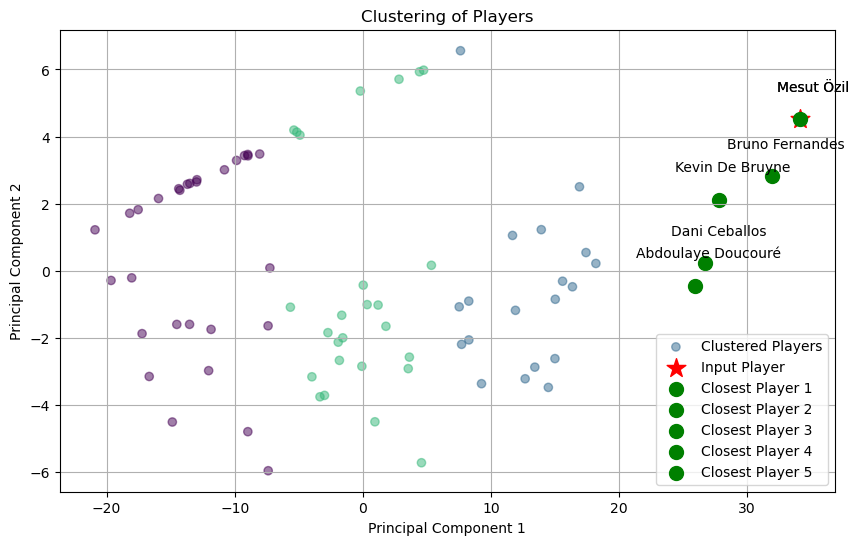

In [389]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
import numpy as np
import matplotlib.pyplot as plt

# 1. User Input
player_name = input("Enter the name of the player you want to find similar players for: ")

# 2. Retrieve Player Data and Filter Positions
player_data = df_per_match[df_per_match['Name'] == player_name].iloc[0]  
input_positions = player_data['position']

# Remove non-numeric and non-per-match columns
columns_to_remove = ['Name', 'Club', 'Nationality', 'Age', 'Appearances', 'name', 'position']
selected_columns = [col for col in df_per_match.columns if col not in columns_to_remove]

# Filter positions
filtered_df = df_per_match[df_per_match['position'].apply(lambda x: any(pos in x for pos in input_positions))]

# Select relevant features
X = filtered_df[selected_columns]

# 3. Apply Clustering Algorithm
num_clusters = 4  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# 4. Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Find the cluster of the input player
player_cluster = kmeans.predict(player_data[selected_columns].values.reshape(1, -1))

# Get indices of players in the same cluster
cluster_indices = np.where(kmeans.labels_ == player_cluster[0])[0]

# Calculate distances of all players in the cluster to the input player
player_data_pca = pca.transform(player_data[selected_columns].values.reshape(1, -1))
distances = pairwise_distances(X_pca[cluster_indices], player_data_pca)

# Sort players by distance and select the top 5 closest players
closest_player_indices = np.argsort(distances.flatten())[:5]
closest_players = filtered_df.iloc[cluster_indices[closest_player_indices]]

# Print the closest players with distances
print("Top 5 closest players:")
closest_players_with_distances = closest_players.copy()  # Create a copy to avoid modifying the original DataFrame
closest_players_with_distances.insert(1, 'Distance', distances[closest_player_indices])  # Add distances as a new column
print(closest_players_with_distances.head())

# Plot all players in the cluster
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5, label='Clustered Players')

# Plot input player
plt.scatter(player_data_pca[:, 0], player_data_pca[:, 1], color='red', marker='*', s=200, label='Input Player')
plt.annotate(player_name, (player_data_pca[:, 0], player_data_pca[:, 1]), textcoords="offset points", xytext=(10,20), ha='center')

# Plot top 5 closest players
for i, idx in enumerate(cluster_indices[closest_player_indices]):
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], color='green', marker='o', s=100, label=f'Closest Player {i+1}')
    plt.annotate(filtered_df.iloc[idx]['Name'], (X_pca[idx, 0], X_pca[idx, 1]), textcoords="offset points", xytext=(10,20), ha='center')

plt.title('Clustering of Players')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


## Performance

### Silhouette Score
Silhouette score measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation).

Silhouette Score: 0.4405645053684154


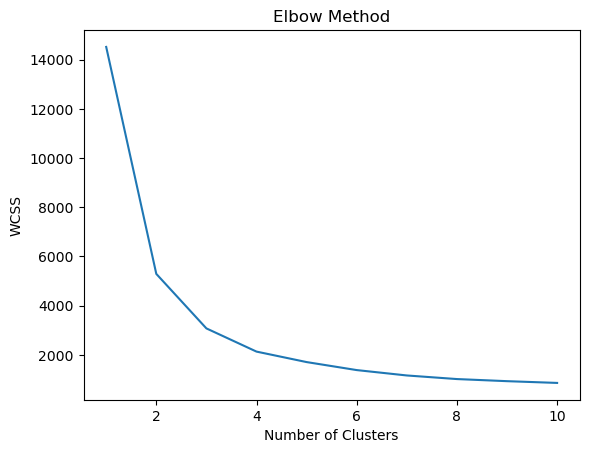

In [390]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate silhouette score
silhouette_avg = silhouette_score(X, kmeans.labels_)
print("Silhouette Score:", silhouette_avg)

# Elbow method for optimal k
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

